# Proof of Concept
******
## Overview
In this section, we will provide a demo of our system.  

For easier reference, the outline of the steps taken in this notebook is as follows:
##### Steps:
1. Import and Install Required Libraries
2. Loading Training and Testing Datasets
3. Data Exploration
4. Data Pre-processing
5. Setting Up the Model
6. Model Evaluation
7. Model Predictions

The first step for this Proof of Concept (POC) will be to import and install required libraries. This will allow us to perform important tasks across this POC such as data preprocessing, data visualisation, the creation of deep learning models and model evaluation. The first step also involves initialising any variables that we may need across multiple parts of the code. Next, we are required to load the data used to train and validate the predictions given by the model. Training datasets are categorised into two types, *unperturbed* and *perturbed*. The *perturbed* training dataset contains the images from the *unpertubed* dataset with digital makeup on. <br>
...
***************

## Step 1: Import and Install Required Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import cv2
import math
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout 
import seaborn as sns
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_curve, auc
from ipykernel import kernelapp as app

In [2]:
epochs = 200
batch_size = 32
img_size = 224
labels = ['female', 'male']

******************
## Step 2: Load Training and Testing Datasets

In [3]:
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=list)

In [4]:
train = get_data('preprocessing/train_data')
val = get_data('preprocessing/val_data')
train_pert = get_data('preprocessing/makeup')

*********************
## Step 3: Data Exploration

In [5]:
def plot_dataset_ratio(l, count, data, femaleLabel, maleLabel):
    for i in data:
        if (i[1] == 0):
            l.append(femaleLabel)      
        else:
            l.append(maleLabel)
        count += 1

<AxesSubplot:>

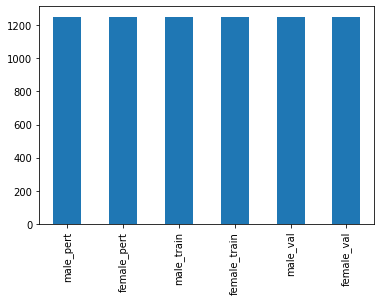

In [6]:
l = []
train_count = 0
val_count = 0
train_pert_count = 0

plot_dataset_ratio(l, train_count, train, "female_train", "male_train")
plot_dataset_ratio(l, train_pert_count, train_pert, "female_pert", "male_pert")
plot_dataset_ratio(l, val_count, val, "female_val", "male_val")

pd.value_counts(pd.Series(data=l)).plot.bar()

**********************
## Step 4: Data Pre-processing

In [7]:
x_train = []
y_train = []
x_train_pert = []
y_train_pert = []
x_val = []
y_val = []

# Unpertubed Dataset
for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
x_train = np.array(x_train) / 255
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

# Perturbed Dataset
for feature, label in train_pert:
    x_train_pert.append(feature)
    y_train_pert.append(label)
x_train_pert = np.array(x_train_pert) / 255
x_train_pert.reshape(-1, img_size, img_size, 1)
y_train_pert = np.array(y_train_pert)

# Validation Dataset
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
x_val = np.array(x_val) / 255
x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

## Step 5: Setting Up the Model

The model that has been built is a Keras Model using the ```Sequential``` API. This will allow us to create models layer by layer and connect them in a sequantial order. The type of neural network that this model uses is a Convolutional Neural Network (CNN). CNN is a deep learning algorithm that consists of neurons with learnable weights and biases. Each artificial neuron accepts an input, performs matrix multiplication (between the input data and the weights) and outputs a non-linear transformation of the data.

The CNN architecture consists of the following distinct components:
1. Input Layer
2. Convolutional Blocks
3. Fully-Connected Layer

### <ins>Input Layer</ins>
The input layer contains the raw pixel values of images represented in a *3D*-matrix. The dimensions is in the order of *W* x *H* x *D*, where *W* and *H* represents the width and height of the image respectively, and *D* represents the color channels. In the case of this POC, we have images with a width of 224 pixels, a height of 224 pixels, and use three color channels (Red, Green, Blue channels).

### <ins>Convolutional Blocks</ins>
This model will have three convolutional blocks that are made up of:
1. <b>Convolutional Layers</b>  
2. <b>ReLu (Activation) Layer</b>
3. <b>Max Pooling Layer</b> 

The first component of the convolutional block are the <b>convolutional</b> (CONV) <b>layers</b>. CONV layers are the core building blocks of any CNN and is where a major part of computation happens. These layers use learnable filters that perform convolution operations that scans through an input and results in an output commonly known as feature maps (Amidi & Amidi, 2018). Using the Keras ```Sequential``` API, we can create and add CONV layers using Keras ```Conv2D```. The important hyperparameters for CONV layers that will be mentioned are: the <b>number of filters</b> used, <b>stride</b>, <b>kernel size</b>, <b>padding</b> and the type of <b>activation function</b>. 

1. The <b>number of filters</b> will affect the depth of the output. For example, to generate four different feature maps we would need four distinct filters, thus creating a depth of four. For our model, the number of filters will vary from filter to filter. This can be accomplished by updating the ```filters``` parameter of our ```Conv2D``` methods.

2. <b>Stride</b> refers to the number of rows and columns the kernel traverses per slide. Smaller strides generally lead to larger outputs, whereas larger strides lead to smaller outputs. For our model, we will be using the default setting by the ```Conv2D``` method, which is a stride of one (1).

3. <b>Kernel size</b> can be represented as an integer or a tuple with two integers that specifies the *2D* convolution window. For our model, it will use a kernel size with a width and height of 3px across all CONV layers. This is accomplished when we set the ```kernel_size``` parameter of our ```Conv2D``` methods to ```(3,3)```

4. There are several types of <b>padding</b>, including same padding, full padding and valid padding. For our model, it will use same padding. This is accomplished when we set the ```padding``` parameter of our ```Conv2D``` methods to ```same```. This will ensure that the output layer is the same size of the input layer.

5. Keras offers multiple types of layer ```activation``` functions, all of which have their own use cases, advantages and disadvantages. For our model, it will use the Rectified-Linear Unit (ReLu) activation function for the ```Conv2D``` and ```Dense``` methods within the convolutional block. This is accomplished when we set the ```activation``` parameter of these methods to ```relu```. 

As additional feature to the layers of our model, we will employ dropout regularisation to prevent our model from overfitting. Overfitting refers to a model that fits the training data too well, hence affecting the model's ability to predict given new and unseen data. Dropout regularisation is a technique that will randomly choose neurons to when training the model. By doing so, the activation of neurons becomes sparse, thus causing the model to improve in its ability to generalise.

The other two components of the convolutional blocks are the <b>ReLu activation layer</b> and <b>max pooling layer</b>. The ReLu activation layer uses a piecewise linear function that determines whether a node will output the given input (if positive) or output zero (otherwise). The max pooling layer, like the convolutional layer, filters across the input volumn and selects the pixel that has the greatest value to send to the output layer.

### <ins>Fully-Connected Layer </ins>
The purpose of the fully-connected (FC) layer is to perform class predictions. The input for this layer will be a flattened vector of nodes that was activated in the earlier part of the model process. To flatten a vector of nodes, we will use the ```Flatten()``` method at the beginning of the FC layer. This will turn *3D* feature maps into a *1D* input tensor. The FC layer will be constructed using ```Dense``` layers. As for the final output layer, it will use the ```softmax``` activation function which can be both used for binary and multi-class problems. This is accomplished by setting ```activation``` parameter in the final ```Dense``` layer to ```softmax```. Once the model is built, the model will then be compiled using the ```Adam``` optimizer with a learning rate of ```0.000001```, a ```SparseCategoricalCrossentropy``` loss and use ```accuracy``` for our performance ```metric```. 

In [8]:
def createModel():
    model = Sequential()
    
    # Input layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(224,224,3)))
    
    # Convolutional Layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully-Connected Layer
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    
    opt = Adam(lr=0.000001)
    model.compile(optimizer = opt , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
    
    return model

To load in a pre-trained model and to avoid repetitive computation, we will the following code and comment out code that performs model training:

In [9]:
# Load model trained on unperturbed data
model = tf.keras.models.load_model('model_best_weights.h5')

# Load model trained on perturbed data
model_pert = tf.keras.models.load_model('model_best_weights_pert.h5') 

********
## Step 6: Model Evaluation and Predictions

In [107]:
ext = [[72.0*2.5, 97.04347826086959*2.25], [188.4521739130435*2.25, 97.04347826086956*2.25], [304.904347826087*2.4, 97.04347826086956*2.4], [421.35652173913047*2.4, 97.04347826086962*2.4]]
target_names = ['female','male']
test_datagen = ImageDataGenerator(rescale = 1./255)
val_gen = test_datagen.flow_from_directory("preprocessing/val_data",
                                                            target_size=(224, 224),
                                                            batch_size=batch_size,
                                                            class_mode='categorical')
# Load history
with open("history/model_history.json") as json_file:
    history = json.load(json_file)
with open("history/model_pert_history.json") as json_pert_file:
    history_pert = json.load(json_pert_file)

# Unperturbed Data
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
### Generates confusion matrix
Y_pred = model.predict(val_gen, 2500 // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
cf_matrix = confusion_matrix(val_gen.classes, y_pred)

# Perturbed Data
acc_pert = history_pert['accuracy']
val_acc_pert = history_pert['val_accuracy']
loss_pert = history_pert['loss']
val_loss_pert = history_pert['val_loss']
### Generates confusion matrix
Y_pred_pert = model_pert.predict(val_gen, 2500 // batch_size)
y_pred_pert = np.argmax(Y_pred_pert, axis=1)
cf_matrix_pert = confusion_matrix(val_gen.classes, y_pred_pert)
### Perturbed history


        
def gen_acc(matrix, prnt=False):
    true_neg = matrix[0][0]
    true_pos = matrix[1][1]
    female_acc = true_neg/1500
    male_acc = true_pos/1500
    global_acc = (true_neg+true_pos)/2500
    if prnt:
        print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    else:
        return female_acc, male_acc, global_acc
    
def gen_gbi(matrix):
    female_acc, male_acc, global_acc = gen_acc(matrix)

    gender_bias_index = "{0:.2%}".format(female_acc - male_acc)
    return "Gender Bias Index: " + gender_bias_index

def plot_train_val_acc_loss():
    epochs_range = range(epochs)

    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(19,10)) 
    fig.suptitle("Unperturbed vs Perturbed", fontsize='x-large')
    fig.subplots_adjust(top=0.85)


    # Model Train on Unperturbed Data
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', c="#f21170")
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', c="#ff8474")
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, loss, label='Training Loss', c="#f21170")
    plt.plot(epochs_range, val_loss, label='Validation Loss', c="#ff8474")
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Model Train on Perturbed Data
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, acc_pert, label='Training Accuracy', c="#9f5f80")
    plt.plot(epochs_range, val_acc_pert, label='Validation Accuracy', c="#583d72")
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, loss_pert, label='Training Loss', c="#9f5f80")
    plt.plot(epochs_range, val_loss_pert, label='Validation Loss', c="#583d72")
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    inv = fig.transFigure.inverted()
    width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
    left_center = inv.transform( (width_left, 1) )
    width_right = ext[2][0]+(ext[3][0]+ext[3][1]-ext[2][0])/2.
    right_center = inv.transform( (width_right, 1) )
    plt.figtext(left_center[0],0.9,"Model Trained on Unperturbed Data", va="center", ha="center", size=20)
    plt.figtext(right_center[0],0.9,"Model Trained on Perturbed Data", va="center", ha="center", size=20)

    plt.show()
    
def gen_cm():
    f,ax = plt.subplots(1,2, sharex=True, figsize=(14,5))

    # Unperturbed Data
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    df_cm = pd.DataFrame(cf_matrix, range(2), range(2))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    labels = np.asarray([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]).reshape(2,2)
    
    # Perturbed Data
    group_counts_pert = ["{0:0.0f}".format(value) for value in
                    cf_matrix_pert.flatten()]
    group_percentages_pert = ["{0:.2%}".format(value) for value in
                         cf_matrix_pert.flatten()/np.sum(cf_matrix_pert)]
    df_cm_pert = pd.DataFrame(cf_matrix_pert, range(2), range(2))
    df_cm_pert.index.name = 'Actual'
    df_cm_pert.columns.name = 'Predicted'
    labels_pert = np.asarray([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts_pert,group_percentages_pert)]).reshape(2,2)
    
    # CM Titles
    width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
    left_center = inv.transform( (width_left, 1) )
    width_right = ext[2][0]+(ext[3][0]+ext[3][1]-ext[2][0])/2.
    right_center = inv.transform( (width_right, 1) )
    plt.figtext(left_center[0],0.95,"Model Trained on Unperturbed Data", va="center", ha="center", size=20)
    plt.figtext(right_center[0],0.95,"Model Trained on Perturbed Data", va="center", ha="center", size=20)

    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=labels, annot_kws={"size": 15}, cmap='YlOrBr', fmt='', ax=ax[0], xticklabels = target_names, yticklabels=target_names)
    sns.heatmap(df_cm_pert, annot=labels_pert, annot_kws={"size": 15}, cmap='Blues', fmt='', ax=ax[1], xticklabels = target_names, yticklabels=target_names)
    sns.set_style("darkgrid")
    plt.show()
    
def gen_cr():
    print("---------------------------------------------------------")
    print("Model trained on Unperturbed Data")
    print("---------------------------------------------------------")
    print(classification_report(val_gen.classes, y_pred, target_names=target_names, zero_division=1))
    print("---------------------------------------------------------")

    print("Model trained on Perturbed Data")
    print("---------------------------------------------------------")
    print(classification_report(val_gen.classes, y_pred_pert, target_names=target_names, zero_division=1))

Found 2500 images belonging to 2 classes.


### Accuracy and Loss

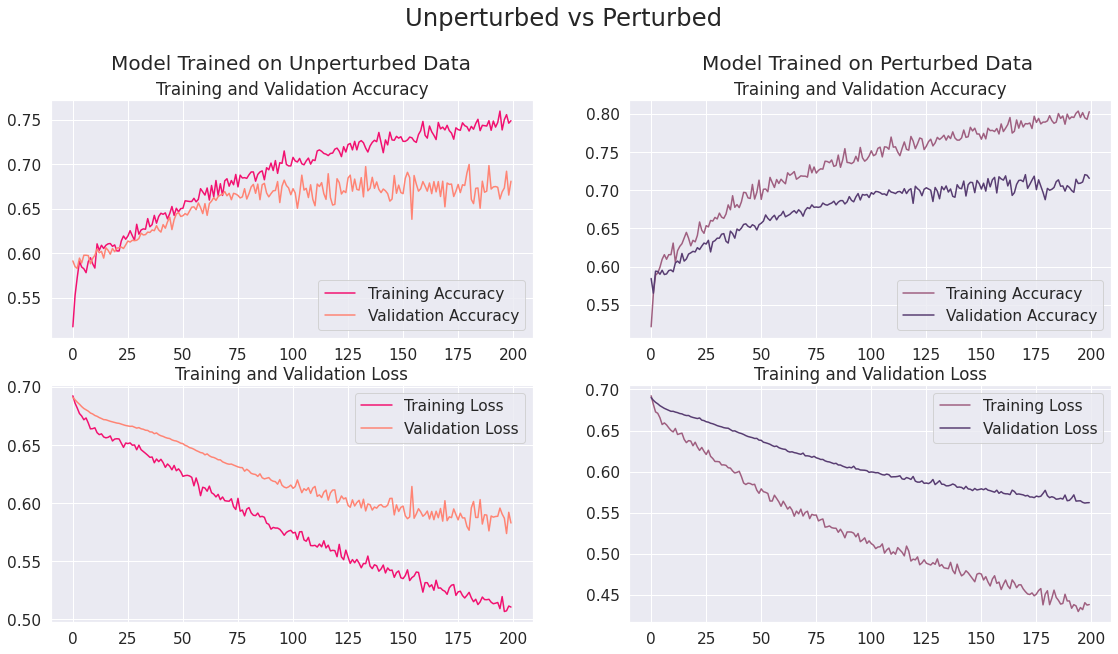

In [108]:
plot_train_val_acc_loss()

### Accuracy and Loss
The figure above is a comparison of our two models, one model has been trained on unperturbed data, and the other one trained on perturbed data. The comparison involves evaluating the training and validation accuracy, and the training and validation loss between the two models. First, we will compare the training and validation accuracy between the two models. Comparing the trend of both lines (Training Accuracy and Validation Accuracy) from the two models, we can see that they are very similar. To elaborate, as the model reaches the number of epochs initialised in Step 1, the training and validation accuracy of the model tends to increase. 

#### <ins>Validation Accuracy and Loss</ins>
This section discusses in more detail, the accuracies and losses between the two models. First, the validation accuracy of the model trained on unperturbed data is ~70% accuracy. On the other hand, the model trained on perturbed data reaches a slightly greater validation accuracy with ~72% accuracy. In other words, we should expect that the model trained on unperturbed data and perturbed data will achieve ~70% and ~72% accuracy on new data respectively. This information is mirrored if we were to compare the validation loss between the two models. Although the two models begin with similar validation losses of ~0.69, at Epoch 200 the model trained on unperturbed data reaches a validation loss of ~0.58 and the other with ~0.56. In sum, the evaluation suggests that in order to achieve greater validation accuracy and loss, we should apply some pertubations to the input images before it is passed to the model. 

#### <ins>Overfitting</ins>
This section discusses a common issue when it comes to training ANN models and that is <b>overfitting</b>. Overfitting is what prevents models from making accurate predictions on new and unseen datasets (Carremans, 2018). Typically, one would think that the more repititions there are for model training, the greater the accuracy. However this is certainly not the case and is how overfitting happens. Luckily, there are ways to identify whether a model is overfitting. One way is to check the validation metrics (accuracy and loss) of the model (Corporate Finance Institude, n.d.). Since validation accuracy and loss can both be used to identify whether a model is overfitting in similar ways, we will only consider validation accuracy for our analysis.

Looking at the validation accuracy for the model trained on unperturbed data, as pointed out earlier at the start of the graph the validation accuracy increases as the epoch number increases. However at around Epoch 75, the validation accuracy seems to no longer have an upwards trend. On the other hand, training accuracy continues to have a rising trend even after Epoch 200. Thus we would say that the model trained on unperturbed data begins to overfit after Epoch 75.

As for the validation accuracy of the model trained on perturbed data, the model faces a similar fate in that in the beginning of the graph it has a growing trend but stops after it reaches a certain number of epochs. The difference between this model and the model trained on unperturbed data is that it seems to only reach this point of overfitting after Epoch 100. Morever, the training accuracy of this model continues to increase even after Epoch 200, just like the model trained on unperturbed data.

#### <ins>Comparing Categorical Accuracies</ins>
Now to evaluate the categorical accuracies between the two models, we will use the ```accuracy_score``` method provided by ```scikit-learn```. Contrary to validation accuracy which validates the ability of a model to generalise, categorical accuracies tests This metric is calculated by summing the number of matches between what is the true value and what was predicted and dividing it by the total number of samples. <br><br>
First, let us generate the ```accuracy_score``` of the model trained on unperturbed data:

In [109]:
# Model trained on unperturbated data
gen_acc(cf_matrix, True)

Overall Categorical Accuracy: 49.80%


Thus, the ```accuracy_score``` of the model trained on unperturbed data was 49.80%. Now let us generate an ```accuracy_score``` for the model trained on perturbed data.

In [110]:
# Model trained on perturbated data
gen_acc(cf_matrix_pert, True)

Overall Categorical Accuracy: 51.16%


As we can see, the ```accuracy_score``` given by the model trained on perturbed data was 51.16%, slightly better than the model trained on unperturbed data. As this POC is a work in progress, we will continue to explore ways in which will improve the categorical accuracy of our model.

### Confusion Matrix
To continue our evaluation of the model, we will be looking at the <b>confusion matrix</b> produced by the ```confusion_matrix``` method provided by ```scikit-learn```. This table will enable us to discuss the performance of our binary classification model using test data where the true values are given. Before moving on, there are some terms which we will define in the context of our project:
- <b>True Positives (TP):</b> The actual image was a male, and the model correctly predicted male
- <b>True Negatives (TN):</b> The actual image was a female, and the model correctly predicted female
- <b>False Positions (FP):</b> The actual image was a female, but the model incorrectly predicted male
- <b>False Negatives (FN):</b> The actual image was a male, but the model incorrectly predicted female 

All confusion matrices hold a great amount of information. For our evaluation we will be analysing the accuracy, precision and recall metrics of our model. Conveniently, ```scikit-learn``` provides us with the ```classification_report``` method that summarises these metrics neatly:

In [118]:
gen_cr()

---------------------------------------------------------
Model trained on Unperturbed Data
---------------------------------------------------------
              precision    recall  f1-score   support

      female       0.50      0.81      0.62      1250
        male       0.49      0.18      0.27      1250

    accuracy                           0.50      2500
   macro avg       0.50      0.50      0.44      2500
weighted avg       0.50      0.50      0.44      2500

---------------------------------------------------------
Model trained on Perturbed Data
---------------------------------------------------------
              precision    recall  f1-score   support

      female       0.51      0.53      0.52      1250
        male       0.51      0.49      0.50      1250

    accuracy                           0.51      2500
   macro avg       0.51      0.51      0.51      2500
weighted avg       0.51      0.51      0.51      2500



<br>
As for the confusion matrices of our two models:

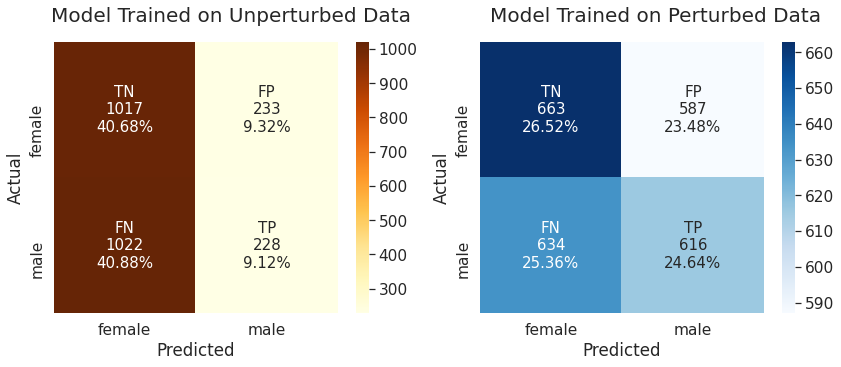

In [117]:
gen_cm()

For our evaluation of accuracy, precision and recall, we will reference the ```classification_report``` and ```confusion_matrix``` of our two distinct models generated above.

Let $f$ and $m$ be subsets of the validation data labelled `female` and `male` respectively.

#### <ins>Accuracy</ins>
Accuracy can tell us how many of the images were correctly labelled over the total number of samples that were made using our test dataset. Since our dataset is balanced well, accuracy is particularly useful (Liu, 2020). If we did have a unbalanced data set that was skewed extremely towards one side, our accuracy may be high but it becomes futile. For example if we had a 100 images and 98 of them were female and only 2 of them were of a male, our model would have a very high chance of correctly classifying an image as female with ~98% accuracy. To avoid this mishap, it is important that we analyse the ratio of the classes of our datasets before doing any model training.

Accuracy of classifying both genders is given by the formula of:

<img src="https://latex.codecogs.com/svg.latex?%5Cfrac%7BTrue%20Positive%20+%20True%20Negative%7D%7BTrue%20Positive%20+%20True%20Negative%20+%20False%20Positive%20+%20False%20Negative%7D" width="600"/>

Since the analysis of accuracies between the two models were completed in an earlier section of this walkthrough, we will continue to analyse other metrics.

#### <ins>Precision</ins>
Precision is a measure of actual True Positives (True Negatives) over all positives (negatives). Precision is particularly useful if the costs of having a False Positive is high. In the context of our project, we would want to prioritise minimizing precision if there is a greater cost to our model predicting male (positive) when the actual image was a female (negative). Since our objective is to eliminate any trace of bias in face recognition models, precision would be as important as any other metric.

Precision of classifying <b>females</b> is given by the formula of:

$$
\frac{TN_f}{TN_f + FN_f}
$$

<img src="https://latex.codecogs.com/svg.latex?%5Cfrac%7BTrue%20Negative%7D%7BTrue%20Negative%20+%20False%20Negative%7D" width="300"/>

Precision of classifying <b>males</b> is given by the formula of:

<img src="https://latex.codecogs.com/svg.latex?%5Cfrac%7BTrue%20Positive%7D%7BTrue%20Positive%20+%20False%20Positive%7D" width="300"/>

where $TN_f$, $FN_f$, $TN_m$, $FN_m$ represent the true negative over $f$, false negative over $f$, true negative over $m$, false negative over $m$ respectively.

Looking at the precision metrics of the two models, we can see that the precision value for male and female are very similar across the two models. This suggests that if our either of our models predicts that an image refers to a male or female, we can be assured that the prediction is a relevant one (Koehrsen, 2018).

#### <ins>Recall</ins>
Recall is a measure of how well our model correctly identifies True Positives or True Negatives . Recall is useful if the costs of having a False Negative is high. In the context of our project, we would want to prioritise minizing recall if there is a greater cost to our model predicting female (negative) when the actual image was male(positive). 

Recall of classifying <b>females</b> is given by the formula of:


Recall of classifying <b>males</b> is given by the formula of:

<img src="https://latex.codecogs.com/svg.latex?%5Cfrac%7BTrue%20Positive%7D%7BTrue%20Positive%20+%20False%20Negative%7D" width="300"/>

### Gender Bias Index

In [ ]:
gen_gbi(cf_matrix)

In [ ]:
gen_gbi(cf_matrix_pert)

********
## Step 7: Making Predictions

Through analysis of the images below, it seems that when the data is perturbed with make up on, it is more likely that the model will predict that the subject is a female. 

Speculations:
- Adding some make up to classified male faces may improve gender biasness in AI
- Removing make up features from females may improve gender biasness in AI

### Without Pertubation

In [ ]:
def predictImage(filename):
    img = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = input_arr.astype('float32') / 255.  # This is VERY important
    predictions = model.predict(input_arr)
    val = np.argmax(predictions, axis=-1)
    
    img1 = image.load_img(filename,target_size=(img_size,img_size))
    plt.imshow(img1)
    if val == 1:
        plt.xlabel("MALE",fontsize=30)
    elif val == 0:
        plt.xlabel("FEMALE",fontsize=30)

In [ ]:
predictImage("random.jpeg")

In [ ]:
predictImage("celeb.jpg")

In [ ]:
predictImage("emma.jpg")

In [ ]:
predictImage("clairo.jpeg")

### With Pertubation

In [ ]:
def predictImagePert(filename):
    img = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = input_arr.astype('float32') / 255.  # This is VERY important
    predictions = model_pert.predict(input_arr)
    val = np.argmax(predictions, axis=-1)
    
    img1 = image.load_img(filename,target_size=(img_size,img_size))
    plt.imshow(img1)
    if val == 1:
        plt.xlabel("MALE",fontsize=30)
    elif val == 0:
        plt.xlabel("FEMALE",fontsize=30)

In [ ]:
predictImagePert("random.jpeg")

In [ ]:
predictImagePert("celeb.jpg")

In [ ]:
predictImagePert("emma.jpg")

In [ ]:
predictImagePert("clairo.jpeg")

## References
- https://developer.nvidia.com/blog/deep-learning-nutshell-core-concepts/
- https://www.tensorflow.org/tutorials/keras/save_and_load
- https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/
- https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
- https://cs231n.github.io/convolutional-networks/https://cs231n.github.io/convolutional-networks/
- https://deeplizard.com/learn/video/daovGOlMbT4
- https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks
- https://www.ibm.com/cloud/learn/convolutional-neural-networks
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
- https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

Confusion Matrix
- https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

Graphs
- https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns

Overfitting
- https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e
- https://corporatefinanceinstitute.com/resources/knowledge/other/overfitting/#:~:text=Overfitting%20can%20be%20identified%20by,model%20is%20affected%20by%20overfitting.

Accuracy, Precision and Recall
- https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c
- https://www.kdnuggets.com/2020/04/performance-evaluation-metrics-classification.html#:~:text=As%20mentioned%2C%20accuracy%20is%20one,good%20choice%20with%20unbalanced%20classes.